In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
 

# Predict Future Sales

Competition: https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/overview


## File descriptions

* ``sales_train.csv`` - the training set. Daily historical data from January 2013 to October 2015.

* ``test.csv`` - the test set. You need to forecast the sales for these shops and products for November 2015.

* ``sample_submission.csv`` - a sample submission file in the correct format.

* ``items.csv`` - supplemental information about the items/products.

* ``item_categories.csv``  - supplemental information about the items categories.

* ``shops.csv``- supplemental information about the shops.

## Data Fields

* ``ID`` - an Id that represents a (Shop, Item) tuple within the test set.
* ``shop_id`` - unique identifier of a shop
* ``item_id`` - unique identifier of a product
* ``item_category_id`` - unique identifier of item category
* ``item_price`` - current price of an item
* ``date`` - date in format dd/mm/yyyy
* ``date_block_num`` - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* ``item_name`` - name of item
* ``shop_name`` - name of shop
* ``item_category_name`` - name of item category

* **Target** ``item_cnt_day`` number of products sold. 🎯

# Auxiliar functions

In [3]:
# Due to the large data to translate and the time between Google Translate API calls,
# this function attempts to parallelise the translation to accelerate this process.

ERROR_COUNT=0

import threading

def _do_translate(serie):

  for i,v in serie.iteritems():

    while True:
      try:
        serie.loc[i] = translator.translate(v, dest="en").text
        break
      except:
        continue


def my_translate(original, workers=1,inplace=False):

  thread_list = []

  window_set = int(len(original)/workers)
  result = pd.Series(original, copy= not inplace)

  for i in range(workers):  

    subset_n = result.loc[i*window_set:(i+1)*window_set]
    t = threading.Thread(target= _do_translate, args=[subset_n])
    t.start()
    thread_list.append(t)
  
  subset_n = result.loc[workers*window_set:] # Los que quedan
  if len(subset_n)>0:
    t = threading.Thread(target= _do_translate, args=[subset_n])
    t.start()
    thread_list.append(t)

  for t in thread_list:
    t.join()
  
  return result


# Importing and clearing data

In [58]:
categories = pd.read_csv("item_categories.csv")
items = pd.read_csv("items.csv")
sales = pd.read_csv("sales_train.csv")
sales_test = pd.read_csv("test.csv")
shops = pd.read_csv("shops.csv")

sample = pd.read_csv("sample_submission.csv")

## Categories

In [5]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
categories.sample(5)

,item_category_name,item_category_id
49,Книги - Методические материалы 1С,49
36,Карты оплаты - Windows (Цифра),36
12,Игровые консоли - PS4,12
82,Чистые носители (штучные),82
45,Книги - Аудиокниги 1С,45


Due to the language difficulties, I'll use a translate library so I could have a  better understanding of the context and choose better strategies.

To submit the results, it's recommendened to evaluate the imapct of translating the features on the final score, becouse it could fall in a error translation, impacting negatively to the results or maybe the translation could derive in a better representation of the features.

In [7]:
#!pip install translate
#from translate import Translator

!pip install googletrans==3.1.0a0
from googletrans import Translator

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
translator= Translator()
translator.translate("Аксессуары - PS3").text

'Accessories - PS3'

In [9]:
categories["item_category_name"].head(10).apply(lambda x: translator.translate(x,dest="en").text)

0    PC - Headsets/Headphones
1           Accessories - PS2
2           Accessories - PS3
3           Accessories - PS4
4           Accessories - PSP
5        Accessories - PSVita
6      Accessories - XBOX 360
7      Accessories - XBOX ONE
8           Tickets (Digital)
9           Delivery of goods
Name: item_category_name, dtype: object

In [10]:
#categories["item_category_name_en"] = my_translate(categories["item_category_name"],workers=40)
#categories["item_category_name_en"].head()

In [11]:
#new_translation =my_translate(categories["item_category_name"],workers=10)
#(categories["item_category_name_en"] == new_translation).value_counts()

## Items

In [12]:
items.head(5)

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [13]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [14]:
#items["item_name_en"] = my_translate(items["item_name"],workers=200)
#items["item_name_en"].head(5)

## Shops


In [15]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [16]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [18]:
# Viable to translate
#shops["shop_name_en"] = my_translate(shops["shop_name"],workers=10)
#shops["shop_name_en"].head()

# TODO: Análisis de palabrás más repetidas en los nombres de shops

## Sales


In [59]:
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [60]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [61]:
sales["date"] = pd.to_datetime(sales["date"],format="%d.%m.%Y")
sales["date"].head()

0   2013-01-02
1   2013-01-03
2   2013-01-05
3   2013-01-06
4   2013-01-15
Name: date, dtype: datetime64[ns]

### Date analysis

In this section, we are looking for patrones in the date. 


In [64]:
print(f"Min date: {sales['date'].min()}")
print(f"Max date: {sales['date'].max()}")

Min date: 2013-01-01 00:00:00
Max date: 2015-10-31 00:00:00


Day sales registered: 1034


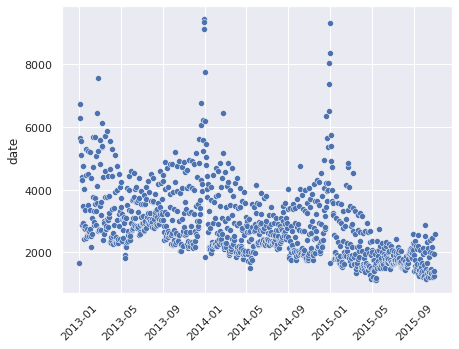

In [65]:
sales["year"] = sales["date"].dt.year
sales["month"] = sales["date"].dt.month

to_plot = sales['date'].value_counts().sort_index()
to_plot = to_plot[to_plot>1]   # Removing outliers
print(f"Day sales registered: {len(to_plot)}")
sns.scatterplot(x=to_plot.index,y=to_plot)
plt.xticks(rotation = 45)
plt.show()

We can see there are tendensies to increase the number of sales at the begining of each year. For this, is important to represent this in the final train set.

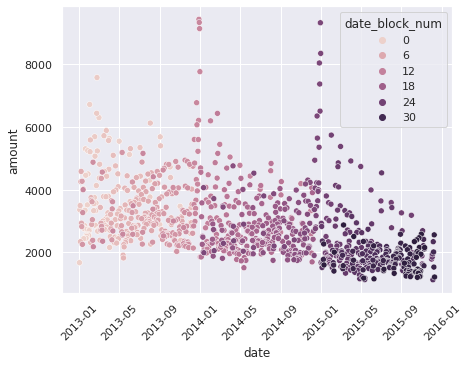

In [46]:
sns.scatterplot(x=grouped["date"], y=grouped["amount"],hue=grouped["date_block_num"])
plt.xticks(rotation = 45)
plt.show()

### Evolution of best-sellers items

In [108]:
sales["item_cnt_day"].sample(5)

1986923    1.0
2039614    1.0
375963     1.0
513934     1.0
2419899    1.0
Name: item_cnt_day, dtype: float64

In [123]:
best_sellers= sales.groupby("item_id")\
                   .agg({"item_cnt_day":"sum"})\
                   .reset_index()

best_sellers.columns = ["item_id","amount"]
#best_sellers = best_sellers.nlargest(n=100,columns="amount")
best_sellers = pd.merge(best_sellers,items,on="item_id")
best_sellers = pd.merge(best_sellers,categories,on="item_category_id")
my_translate(best_sellers["item_name"],inplace=True,workers=5)
my_translate(best_sellers["item_category_name"],inplace=True,workers=5)
best_sellers.head()


KeyboardInterrupt: ignored

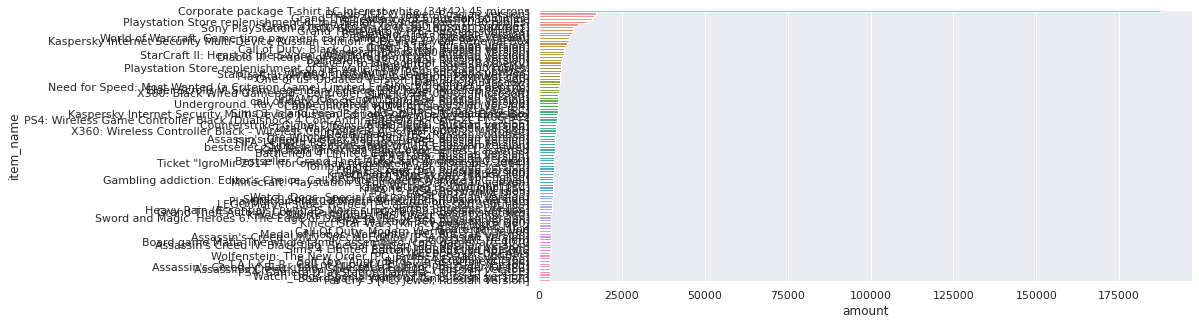

In [117]:
#sns.barplot(data=best_sellers[["item_name","amount"]].sort_values("amount",ascending=False),x="amount",y="item_name")

In [118]:
sales["best_seller_tag"] = sales["item_id"].isin(best_sellers["item_id"].values)
sales.loc[sales["best_seller_tag"]==True,"best_seller_tag"] = sales.loc[sales["best_seller_tag"],"item_id"]
sales.loc[sales["best_seller_tag"] == False,"best_seller_tag"] = "other"
sales.head(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,best_seller_tag
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,other
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,other
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,other
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,other
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,other


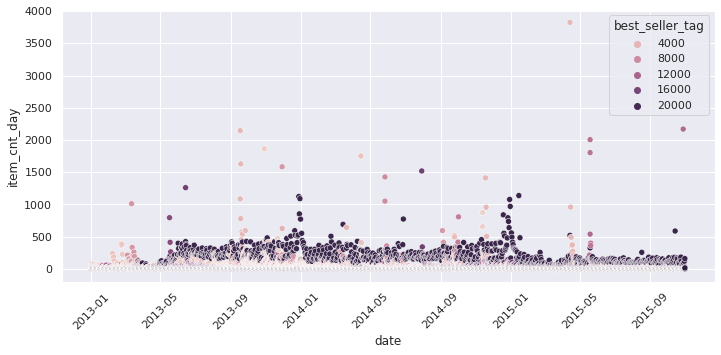

In [121]:
to_plot = sales.groupby(["date","best_seller_tag"]).agg({"item_cnt_day":"sum"}).reset_index()
to_plot = to_plot[to_plot["best_seller_tag"]!="other"]
sns.scatterplot(data=to_plot,x="date",y="item_cnt_day",hue="best_seller_tag")
plt.xticks(rotation = 45)
plt.show()

In [122]:
cat_best_sellers = best_sellers.groupby(["item_category_id","item_category_name"])\
                               .agg({"amount":"sum"})

sales["best_seller_tag"] = sales["item_id"].isin(best_sellers["item_id"].values)
sales.loc[sales["best_seller_tag"]==True,"best_seller_tag"] = sales.loc[sales["best_seller_tag"],"item_category"]
sales.loc[sales["best_seller_tag"] == False,"best_seller_tag"] = "other"
sales.head(5)

KeyError: ignored

In [31]:


grouped = sales[["year","month","item_price"]].groupby(["year","month"]).agg({"item_price":["max","mean","std"]})
grouped.columns = grouped.columns.get_level_values(1)
grouped.head(5)

max        mean          std
year month                                  
2013 1      32990.0  697.834520  1201.195488
     2      25500.0  701.674835  1153.127393
     3      32990.0  702.466212  1119.976143
     4      29700.0  671.825293  1113.401466
     5      32990.0  678.349465  1106.635326

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


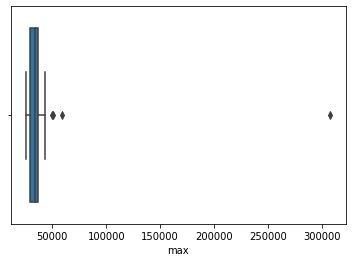

In [32]:
#sns.boxplot(grouped["max"])
sns.boxplot(grouped["max"])
plt.show()

In [33]:
grouped["max"].value_counts()

27990.0     5
32990.0     4
36990.0     4
35300.0     3
27100.0     3
33490.0     3
42990.0     1
31990.0     1
35490.0     1
35990.0     1
49782.0     1
30600.0     1
40900.0     1
25500.0     1
50999.0     1
307980.0    1
42000.0     1
59200.0     1
29700.0     1
34490.0     1
Name: max, dtype: int64

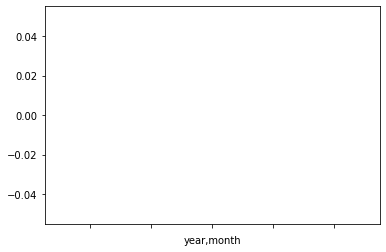

In [34]:
# Remove the "outlier" value 
to_plot = grouped[grouped["max"] < 20000]
to_plot 
to_plot["max"].plot()
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()

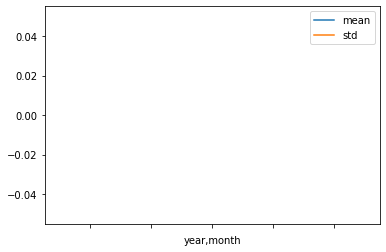

In [35]:
to_plot[["mean","std"]].plot()
plt.xticks(rotation = 45) # Rotates X-Axis Ticks by 45-degrees
plt.show()